# 神经网络与微分方程了解

微分方程和神经网络的结合近两年已经成为了研究热点，这里了解一些作为常识。

参考：

- [Neural ODEs: breakdown of another deep learning breakthrough](https://towardsdatascience.com/neural-odes-breakdown-of-another-deep-learning-breakthrough-3e78c7213795)
- [神经网络常微分方程 (Neural ODEs) 解析](https://zhuanlan.zhihu.com/p/77587163)
- [msurtsukov/neural-ode](https://github.com/msurtsukov/neural-ode)
- [【论文阅读17】ODE-Net——从离散化的ResNet到连续化ODE的模拟](https://maxliu245.github.io/2020/08/21/%E3%80%90%E8%AE%BA%E6%96%87%E9%98%85%E8%AF%BB17%E3%80%91ODE-Net%E2%80%94%E2%80%94%E4%BB%8E%E7%A6%BB%E6%95%A3%E5%8C%96%E7%9A%84ResNet%E5%88%B0%E8%BF%9E%E7%BB%AD%E5%8C%96ODE%E7%9A%84%E6%A8%A1%E6%8B%9F/)
- [天生一对，硬核微分方程与深度学习的「联姻」之路](https://zhuanlan.zhihu.com/p/66100816)

## 为什么我们关注常微分方程？

首先，快速简要概括一下常微分方程是什么。常微分方程描述了某些由一个变量决定的过程随时间的变化。这个时间的变化通过下面的微分方程来描述。

$$ \frac{dx}{dt} + x = 1 $$

通常情况下，如果我们知道了某些初始条件（过程开始的地方），并且我们想了解这个过程将如何变化成某些最终状态，我们才能讨论解这个微分方程。求解函数也被叫做积分曲线（因为我们可以通过对这个方程积分得到方程的解x(t)）

In [1]:
from sympy import dsolve, Eq, symbols, Function

t = symbols('t')
x = symbols('x', cls=Function)
deqn1 = Eq(x(t).diff(t), 1 - x(t))
sol1 = dsolve(deqn1, x(t))

In [2]:
sol1

Eq(x(t), C1*exp(-t) + 1)

C1为常数，可以在给定初始条件时进行确定。如果以恰当的形式给出微分方程，我们可以用解析法进行求解，但通常是采用数值方法求解。最古老和最简单的算法之一是欧拉法:其核心思想是用切线逐步逼近求解函数。

![](imgs/image001.png)

https://tutorial.math.lamar.edu/Classes/DE/EulersMethod.aspx

具体公式就是：

对方程$$\frac{dy}{dt}=f(t,y), y(t_0)=y_0$$

其在n个时间步长的离散网格上的解是
$$y_{n+1}=y_n+f(t_n,y_n)\cdot (t_{n+1}-t_n)$$

关于微分方程的更多细节，特别是如何用Python编写它们以及它们的解决方法，建议去看看[这本书](https://www.springer.com/gp/book/9783319781440)，在化学、物理和工业领域中也有很多这种时间演化过程的例子，均可以用微分方程来描述。此外，对于微分方程与ML模型相关的其他想法，请访问[此资源](https://julialang.org/blog/2019/01/fluxdiffeq)。与此同时，仔细看看欧拉方程，难道它没有让你想起最近的深度学习架构中的任何东西吗?

## 残差网络是一种微分方程的解吗？

确实是这样的！$y_{n+1} = y_n + f(t_n, y_n)$就是ResNet中的一个残差连接，其中一层的输出$y_{n+1}$是$f(t_n,y_n)$本身的输出和该层的输入$y_n$的总和。这基本上是神经 ODE 的主要思想：神经网络中的一连串残差块基本上就是欧拉方法求 ODE 的解！ 在这种情况下，系统的初始条件是“时间” 0，它表示神经网络的第一层，因为x(0)将服务于正常输入，可以是时间序列，图像，任何你想要的！“时间” t的最终条件将是神经网络的期望输出：标量值、表示类别的向量或其他任何东西。

如果我们还记得，这些残差连接是欧拉方法的离散化时间步长，这意味着我们可以调节神经网络的深度，只需选择使解（又名神经网络）更准确或更不准确的离散化方案即可。我们甚至可以使它成为无限层！

![](imgs/1_gRSMxVqVXB27jXWqOR8TbA.png)

如图，是固定层数的 ResNet 和灵活层数的 ODENet 的区别。

ODE 的欧拉求解方法是不是太原始了？确实如此，所以让我们用一些抽象概念替换 ResNet / EulerSolverNet作为 ODESolveNet，其中 ODESolve 将是一个函数，它为 ODE（我们的神经网络本身）提供了一个比 Euler 方法更准确的解决方案。网络架构现在可能如下所示：

```Python
nn = Network(
  Dense(...), # making some primary embedding
  ODESolve(...), # "infinite-layer neural network"
  Dense(...) # output layer
)
```

我们忘记了一件事……神经网络是一个可微函数，因此我们可以使用基于梯度的优化程序对其进行训练。我们应该如何通过ODESolve() 函数进行反向传播？在我们的例子中它实际上也是一个黑匣子。特别是，我们需要输入和动力学参数的损失函数梯度。这个数学技巧被称为adjoint sensitivity method伴随灵敏度法。更多细节需要参考[原论文](https://arxiv.org/pdf/1806.07366.pdf)和[这个教程](https://nbviewer.jupyter.org/github/msurtsukov/neural-ode/blob/master/Neural%20ODEs.ipynb)（本文件夹下已经将其翻译为中文了，在3.2），但本质在下图中的描述（L代表我们要优化的主要损失函数）：

![](imgs/1_GnfnLalKwTJDIKEVescgBA.png)

简而言之，与描述过程的原始动力系统一起，伴随系统通过链式法则（这是众所周知的反向传播的基础所在）向后描述过程中每个点的导数状态。正是从它，我们可以通过初始状态获得导数，并且以类似的方式，通过建模动力系统函数的参数（一个“残差块”，或传统欧拉方法中的离散化步骤） .

有关更多详细信息，建议观看该论文的一位作者本人的介绍:

[油管视频](https://youtu.be/V6nGT0Gakyg)

## 神经 ODE 的可能应用

首先，使用它们代替“普通 ResNets”的优势和动机：

- 内存效率：我们不需要在反向传播时存储所有参数和梯度
- 自适应计算：我们可以通过离散化方案来平衡速度和准确性，此外，在训练和推理时让它有所不同
- 参数效率：附近“层”的参数自动绑定在一起（见[论文](https://arxiv.org/pdf/1806.07366.pdf)）
- Normalizing flows new type of invertible density models
- 连续时间序列模型：连续定义的动态系统可以自然地吸收任意时间点的数据。

## 学习动力系统

正如我们之前看到的，微分方程被广泛使用，来描述复杂的连续过程。当然，在现实生活中，我们的观察为离散过程，最重要的是，在时间 t_i 处的许多观察可能会丢失。假设想用神经网络对这样的系统进行建模。在经典序列建模范式中，将如何处理这种情况？以某种方式将它扔到循环神经网络上，这甚至不是为它设计的。

在这一部分，我们将检查神经 ODE 将如何处理它们。

设置如下：

1. 定义ODE 本身，我们将建模为 PyTorch nn.Module()
2. 定义一个简单的（或不是真正的）神经网络，它将对从 h_t 到 h_{t+1} 的两个接连动态步骤之间的动态进行建模，或者在动态系统的情况下，表达为x_t 和 x_{t+1}。
3. 运行通过 ODE 求解器反向传播的优化过程，并最大限度地减少实际动态和建模动态之间的差异。

在以下所有实验中，神经网络将只是一个跟随（据说这足以对具有两个变量的简单函数进行建模）

接下来，展示建模的动态系统在代码中的样子，以及 ODENet 如何适应系统随时间的演变和相图（原文有更多例子）。

In [3]:
import os
import time
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from torchdiffeq import odeint

In [4]:
batch_time = 10
batch_size = 20
data_size = 200

viz = True

In [5]:
def get_batch():
    s = torch.from_numpy(np.random.choice(np.arange(data_size - batch_time, dtype=np.int64), batch_size, replace=False))
    batch_y0 = true_y[s]  # (M, D)
    batch_t = t[:batch_time]  # (T)
    batch_y = torch.stack([true_y[s + i] for i in range(batch_time)], dim=0)  # (T, M, D)
    return batch_y0, batch_t, batch_y


def makedirs(dirname):
    if not os.path.exists(dirname):
        os.makedirs(dirname)

In [6]:
DATA_TYPE = 'data/NNET_MORE'

In [7]:
if viz:
    makedirs(DATA_TYPE)
    import matplotlib.pyplot as plt

def visualize(true_y, pred_y, odefunc, itr):
  
    if viz:
      
        plt.figure()
        plt.plot(t.numpy(), true_y.numpy()[:, 0, 0], t.numpy(), true_y.numpy()[:, 0, 1], 'g-')
        plt.plot(t.numpy(), pred_y.numpy()[:, 0, 0], '--', t.numpy(), pred_y.numpy()[:, 0, 1], 'b--')
        plt.savefig(DATA_TYPE + '/ts' + str(itr) + '.png')
        plt.show()
        
        plt.figure()
        plt.plot(true_y.numpy()[:, 0, 0], true_y.numpy()[:, 0, 1], 'g-')
        plt.plot(pred_y.numpy()[:, 0, 0], pred_y.numpy()[:, 0, 1], 'b--')
        plt.savefig(DATA_TYPE + '/phase' + str(itr) + '.png')
        plt.show()

In [8]:
class RunningAverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self, momentum=0.99):
        self.momentum = momentum
        self.reset()

    def reset(self):
        self.val = None
        self.avg = 0

    def update(self, val):
        if self.val is None:
            self.avg = val
        else:
            self.avg = self.avg * self.momentum + val * (1 - self.momentum)
        self.val = val

In [9]:
class ODEFunc(nn.Module):

    def __init__(self):
        super(ODEFunc, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(2, 50),
            nn.Tanh(),
            nn.Linear(50, 2),
        )

        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.1)
                nn.init.constant_(m.bias, val=0)

    def forward(self, t, y):
        return self.net(y)


In [10]:
true_y0 = torch.tensor([[1., 1.]])
t = torch.linspace(-1., 1., data_size)

# true_A = torch.tensor([[-0.1, 2.0], [-2.0, -0.1]])
# true_A = torch.randn(2, 2)/2.

# a, b, c, d = 1.5, 1.0, 3.0, 1.0
# true_A = torch.tensor([[0., -b*c/d], [d*a/b, 0.]])

# true_A2 = torch.tensor([[-0.1, -0.5], [0.5, -0.1]])
# true_B2 = torch.tensor([[0.2, 1.], [-1, 0.2]])

class Lambda(nn.Module):

    def forward(self, t, y):
        return torch.mm(y, true_A)
   
      
class Lambda2(nn.Module):
    
    def __init__(self, A, B):
        super(Lambda2, self).__init__()
        self.A = nn.Linear(2, 2, bias=False)
        self.A.weight = nn.Parameter(A)
        self.B = nn.Linear(2, 2, bias=False)
        self.B.weight = nn.Parameter(B)
    
    def forward(self, t, y):
        xTx0 = torch.sum(y * true_y0, dim=1)
        dxdt = torch.sigmoid(xTx0) * self.A(y - true_y0) + torch.sigmoid(-xTx0) * self.B(y + true_y0)
        return dxdt
      
# with torch.no_grad():
#     true_y = odeint(Lambda2(true_A2, true_B2), true_y0, t, method='dopri5')
    
# with torch.no_grad():
#     true_y = odeint(Lambda(), true_y0, t, method='dopri5')

In [11]:
true_y0 = torch.tensor([[1., 1.]])
t = torch.linspace(-15., 15., data_size)


class Lambda3(nn.Module):
  
    def __init__(self):
        super(Lambda3, self).__init__()
        self.fc1 = nn.Linear(2, 25, bias = False)
        self.fc2 = nn.Linear(25, 50, bias = False)
        self.fc3 = nn.Linear(50, 10, bias = False)
        self.fc4 = nn.Linear(10, 2, bias = False)
        self.relu = nn.ELU(inplace=True)
        
    def forward(self, t, y):
        x = self.relu(self.fc1(y * t))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.relu(self.fc4(x))
        return x
     
with torch.no_grad():
    true_y = odeint(Lambda3(), true_y0, t, method='dopri5')

In [12]:
class ODEFunc(nn.Module):

    def __init__(self):
        super(ODEFunc, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(2, 150),
            nn.Tanh(),
            nn.Linear(150, 50),
            nn.Tanh(),
            nn.Linear(50, 50),
            nn.Tanh(),
            nn.Linear(50, 2),
        )

        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.1)
                nn.init.constant_(m.bias, val=0)

    def forward(self, t, y):
        return self.net(y)


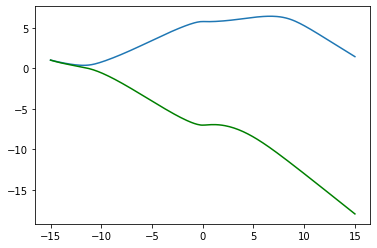

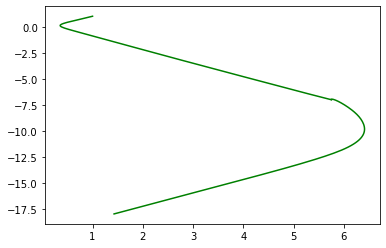

In [13]:
plt.figure()
plt.plot(t.numpy(), true_y.numpy()[:, 0, 0], t.numpy(), true_y.numpy()[:, 0, 1], 'g-')
plt.show()

plt.figure()
plt.plot(true_y.numpy()[:, 0, 0], true_y.numpy()[:, 0, 1], 'g-')
plt.show()

Iter 0100 | Total Loss 2.887623


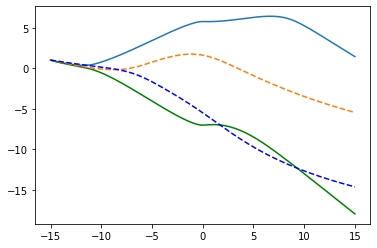

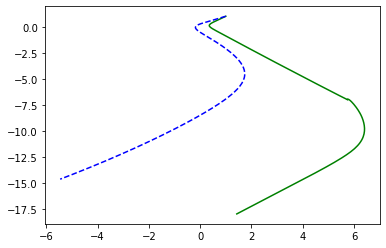

Iter 0200 | Total Loss 1.619922


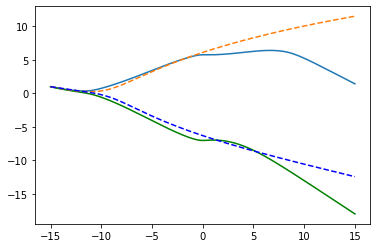

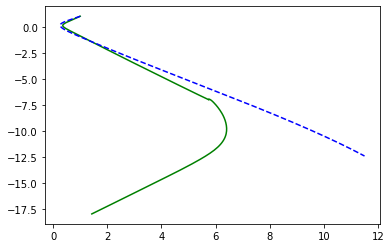

Iter 0300 | Total Loss 1.875805


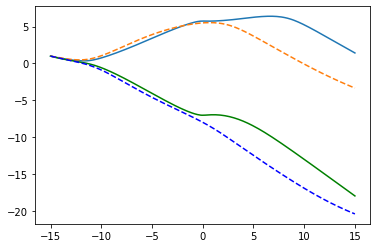

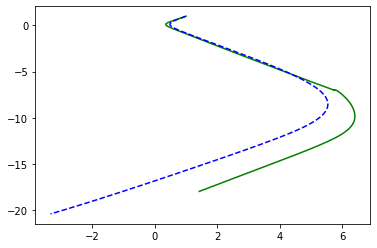

Iter 0400 | Total Loss 0.361153


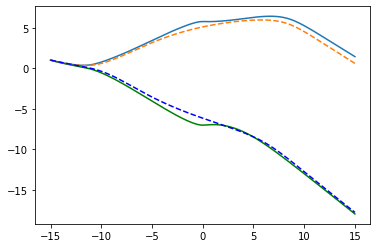

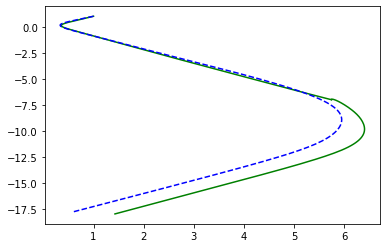

Iter 0500 | Total Loss 0.661230


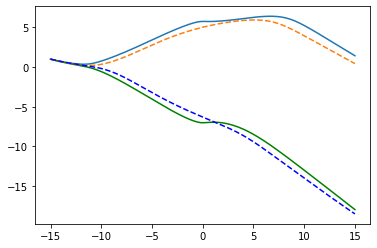

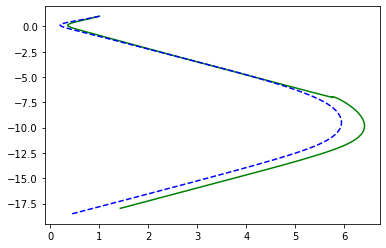

In [15]:
ii = 0
niters = 500

func = ODEFunc()
optimizer = optim.RMSprop(func.parameters(), lr=1e-3)
end = time.time()

time_meter = RunningAverageMeter(0.97)
loss_meter = RunningAverageMeter(0.97)

for itr in range(1, niters + 1):
    optimizer.zero_grad()
    batch_y0, batch_t, batch_y = get_batch()
    pred_y = odeint(func, batch_y0, batch_t)
    loss = torch.mean(torch.abs(pred_y - batch_y))
    loss.backward()
    optimizer.step()

    time_meter.update(time.time() - end)
    loss_meter.update(loss.item())

    if itr % 100 == 0:
        with torch.no_grad():
            pred_y = odeint(func, true_y0, t)
            loss = torch.mean(torch.abs(pred_y - true_y))
            print('Iter {:04d} | Total Loss {:.6f}'.format(itr, loss.item()))
            visualize(true_y, pred_y, func, ii)
            ii += 1

    end = time.time()